<a href="https://colab.research.google.com/github/Bogula/KISS/blob/main/tomato_disease_detection_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import neccessary packages

In [ ]:
import numpy as np
import pickle
import cv2
#import tensorflow as tf
!pip install visualkeras
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization

#from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
!wget https://bogula.org/cloud/index.php/s/YyjL6oyMZaHPQAi/download

In [ ]:
!unzip download
!rm -r __MACOSX 

In [4]:
EPOCHS =10
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/PlantVillage'
width=256
height=256
depth=3

Function to convert images to array

In [5]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetch images from directory

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_disease_folder in root_dir :
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_disease_folder}")
            print(plant_disease_image_list)     
            
            for image in plant_disease_image_list[:400]:
                image_directory = f"{directory_root}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

Get Size of Processed Image

In [ ]:
image_size = len(image_list)
image_size

Tomato_Late_blight


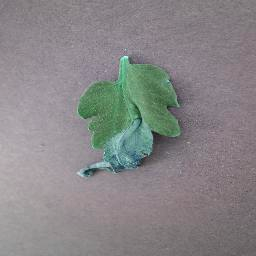

In [14]:
data=image_list[358]
print(label_list[358])
import numpy as np
from keras.preprocessing.image import array_to_img
img = data
b=array_to_img(img)
b


Transform Image Labels uisng [Scikit Learn](http://scikit-learn.org/)'s LabelBinarizer

In [15]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

Print the classes

In [16]:
print(label_binarizer.classes_)

['Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [17]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [18]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [19]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Model Summary

In [ ]:
model.summary()

In [ ]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True)

In [22]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [23]:
EPOCHS = 20
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

NameError: ignored

In [ ]:
EPOCHS = 20
history = model.fit(
    x_train, y_train, batch_size=BS,
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Plot the train and val curve

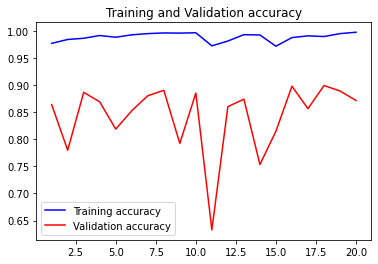

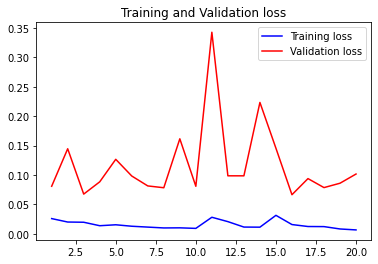

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Model Accuracy

In [30]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)

print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
25/25 [==============================] - 1s 20ms/step - loss: 0.1015 - accuracy: 0.8717
Test Accuracy: 87.16981410980225


Tomato_Spider_mites_Two_spotted_spider_mite


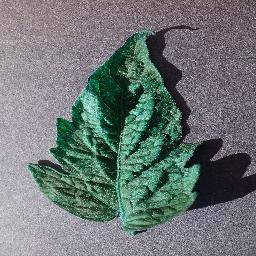

In [31]:
imgx = 101

data=x_test[imgx]
label = y_test[imgx]
print(label_binarizer.classes_[label.argmax()])
#label_binarizer.inverse_transform(label)
import numpy as np
from keras.preprocessing.image import array_to_img
img = data
b=array_to_img(img)
b



In [32]:
predictions=model.predict(x_test)
#a[5].argmax()

In [33]:
label_binarizer.classes_[predictions[imgx].argmax()]

'Tomato_Spider_mites_Two_spotted_spider_mite'

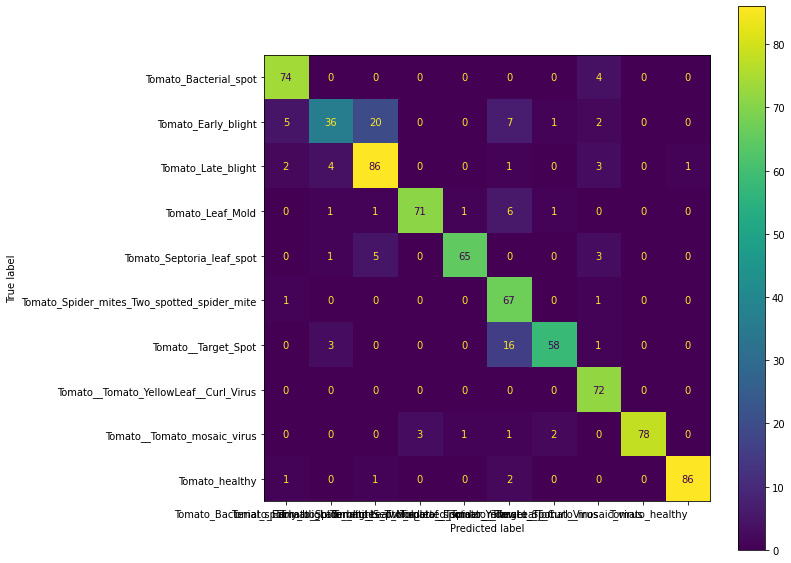

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


n_y_test = np.argmax(y_test, axis=1)
n_predictions=np.argmax(predictions, axis=1)
cm = confusion_matrix(n_y_test, n_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_binarizer.classes_)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_yticklabels(labels=label_binarizer.classes_, rotation=0, ha="right",rotation_mode='anchor')
ax.set_xticklabels(labels=label_binarizer.classes_, rotation=45, ha="right",rotation_mode='anchor')
#ax.tick_params(rotation=60)
#ax.set_xtickrotation(90)
disp.plot(ax=ax)


Save model using Pickle

In [ ]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('tomatomodel.pkl', 'wb'))

[INFO] Saving model...
INFO:tensorflow:Assets written to: ram://021ae54c-84f4-41b2-8839-0bfea0152de0/assets


INFO:tensorflow:Assets written to: ram://021ae54c-84f4-41b2-8839-0bfea0152de0/assets
